In [1]:

import pandas as pd
import re
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# !pip install transformers

# from transformers import pipeline





nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
df = pd.read_csv('X:/home/comp creativity/AITA generator/aita_clean.csv', low_memory=True)

###Drop Nan Values
df=df.dropna()

# Filter the data for each class
class_0 = df[df['is_asshole'] == 0]
class_1 = df[df['is_asshole'] == 1]

# Sample an equal number of instances from each class
sample_size = 5000
class_0_sample = class_0.sample(sample_size, random_state=42)
class_1_sample = class_1.sample(sample_size, random_state=42)

# Combine the sampled data and shuffle it
df = pd.concat([class_0_sample, class_1_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Combine title and body
df['combined_text'] = df['title'] + ' ' + df['body']

## Get the Independent Features

X = df['combined_text']

## Get the Dependent features
y = df['is_asshole']
# Reset index
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
y.value_counts()
X.shape
y.shape
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\da476/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\da476/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole,combined_text
0,eqeu87,1.579343e+09,AITA for raging at family game night?,My family and I played a casual game of Trivia...,False,asshole,15,60.0,1,AITA for raging at family game night? My famil...
1,c1a8rl,1.560694e+09,AITA for not saying Happy Fathers Day to my st...,he’s been in my life since i was 10 but we’ve ...,False,not the asshole,4,15.0,0,AITA for not saying Happy Fathers Day to my st...
2,cmf3u0,1.565031e+09,AITA for wanting the rug shaken outside?,I was cleaning the bathroom floor and my frien...,False,not the asshole,3,26.0,0,AITA for wanting the rug shaken outside? I was...
3,b5vis1,1.553636e+09,"AITA for saying ""i dont care"" to my one year old?",My girlfriend and i were getting ready to go t...,1553636452.0,no assholes here,6,18.0,0,"AITA for saying ""i dont care"" to my one year o..."
4,ewv765,1.580506e+09,AITA for calling mall security when a woman le...,I just read the AITA from November about leavi...,False,not the asshole,134,77.0,0,AITA for calling mall security when a woman le...


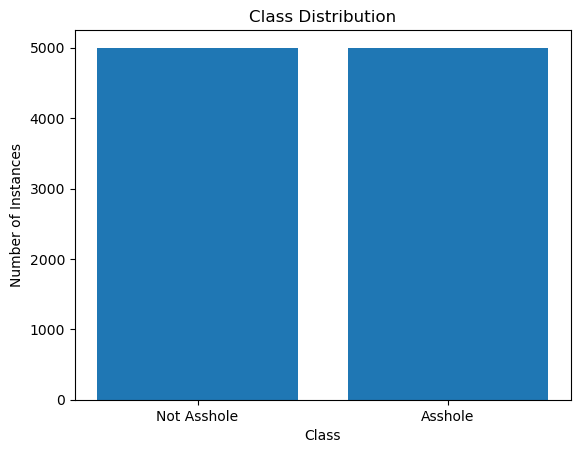

In [2]:
import matplotlib.pyplot as plt

# Count the number of instances for each class
class_counts = df['is_asshole'].value_counts()

# Create a bar graph
plt.bar(['Not Asshole', 'Asshole'], class_counts)

# Add axis labels and title
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')

# Show the graph
plt.show()


In [3]:
df.shape

df["combined_text"][9]


'AITA for not giving my dad a second chance? A little backstory, when my mom met my biological father and had me, he was married to another woman. He kept my mother and me a secret for about 2 years, his wife eventually found out and divorced him. He turned to drugs and alcohol and began harassing and abusing my mother, eventually leading to her getting a restraining order. About a year after that, my mother met her now husband. When my step dad decided he wanted to adopt me, my bio dad agreed to give up his parental rights as long as my mom no longer pursued him for back pay in child support, and so long as he was allowed to send me gifts every now and again. I never received so much as a birthday card, and did not hear from him my entire childhood. \n\nI\'m now 21 years old, and my biological father reached out to me. He has stage 4 cancer, found god, and would like to try and have a relationship with me. I have no desire to do this, my "step dad" is my father in my eyes. He raised m

In [4]:
import re
from nltk.corpus import stopwords
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
# Split the data into train and test sets before preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

def preprocess_text(texts):
    corpus = []
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

    for text in texts:
        # Lowercase
        text = text.lower()

        # Remove HTML tags
        text = remove_tags(text)

        # Remove punctuations and numbers
        text = re.sub('[^a-zA-Z]', ' ', text)

        # Remove single characters
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

        # Remove multiple spaces
        text = re.sub(r'\s+', ' ', text)

        # Remove stopwords
        text = pattern.sub('', text)

        corpus.append(text)

    return corpus

# Preprocess the training and test sets separately
X_train_preprocessed = preprocess_text(X_train)
X_test_preprocessed = preprocess_text(X_test)


In [5]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [6]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

32436

In [7]:
# Padding to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [8]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True, name='{}_W'.format(self.name))
        self.b = self.add_weight(shape=(input_shape[1], 1), initializer='zeros', trainable=True, name='{}_b'.format(self.name))
        super(Attention, self).build(input_shape)

    def call(self, x):
        q = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(q, axis=1)
        return K.sum(x * a, axis=1)


In [9]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [10]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [11]:
embedding_matrix.shape

(32436, 100)

In [12]:
from keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.layers import Dropout

# Neural Network architecture

lstm_attention_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_attention_model.add(embedding_layer)
lstm_attention_model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Add return_sequences=True
lstm_attention_model.add(Attention())  # Add the attention layer here
lstm_attention_model.add(Dropout(0.2))

lstm_attention_model.add(Dense(1, activation='sigmoid'))

# Model compiling
lstm_attention_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_attention_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          3243600   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         234496    
 l)                                                              
                                                                 
 attention (Attention)       (None, 256)               356       
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 3,478,709
Trainable params: 235,109
Non-trainable params: 3,243,600
________________________________________

In [13]:
lstm_attention_model_history = lstm_attention_model.fit(X_train, y_train, batch_size=128, epochs=11, verbose=1, validation_split=0.2)

# Evaluate the model
y_pred_probs = lstm_attention_model.predict(X_test)

# Convert probabilities to class labels
y_pred = (y_pred_probs > 0.5).astype("int32")
y_pred = y_pred[:, 0]  # Only consider the first class label

# Check the shape of y_pred
print("y_pred shape:", y_pred.shape)

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Epoch 1/11
42/42 [==============================] - 115s 3s/step - loss: 0.6968 - acc: 0.5039 - val_loss: 0.6887 - val_acc: 0.5567
Epoch 2/11
42/42 [==============================] - 111s 3s/step - loss: 0.6968 - acc: 0.5112 - val_loss: 0.7066 - val_acc: 0.4716
Epoch 3/11
42/42 [==============================] - 124s 3s/step - loss: 0.6899 - acc: 0.5267 - val_loss: 0.6881 - val_acc: 0.5313
Epoch 4/11
42/42 [==============================] - 120s 3s/step - loss: 0.6898 - acc: 0.5358 - val_loss: 0.7022 - val_acc: 0.4873
Epoch 5/11
42/42 [==============================] - 120s 3s/step - loss: 0.6854 - acc: 0.5485 - val_loss: 0.6813 - val_acc: 0.5649
Epoch 6/11
42/42 [==============================] - 122s 3s/step - loss: 0.6854 - acc: 0.5468 - val_loss: 0.6886 - val_acc: 0.5381
Epoch 7/11
42/42 [==============================] - 128s 3s/step - loss: 0.6835 - acc: 0.5511 - val_loss: 0.6790 - val_acc: 0.5612
Epoch 8/11
42/42 [==============================] - 127s 3s/step - loss: 0.6799 - a

In [14]:
score = lstm_attention_model.evaluate(X_test, y_test, verbose=1)

104/104 [==============================] - 4s 35ms/step - loss: 0.6822 - acc: 0.5670


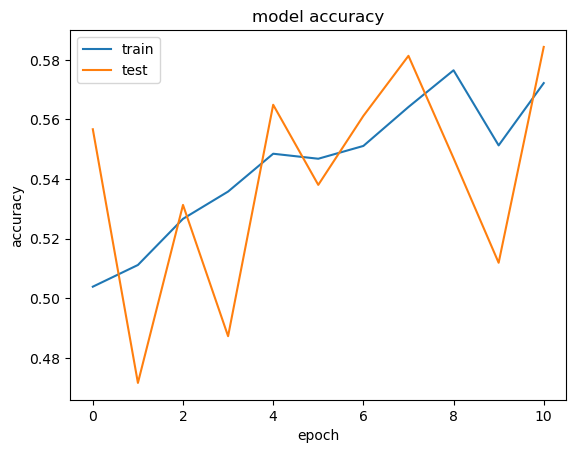

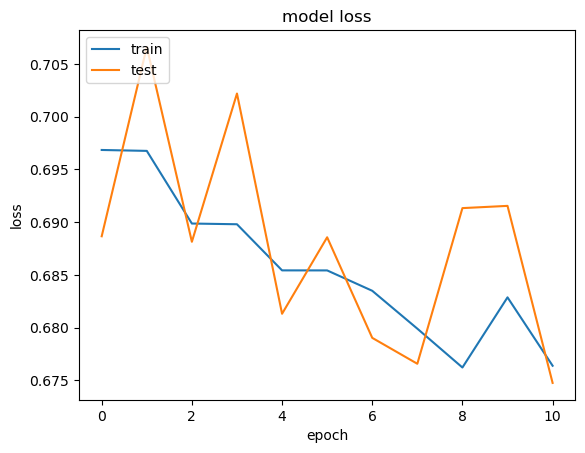

In [15]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_attention_model_history.history['acc'])
plt.plot(lstm_attention_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_attention_model_history.history['loss'])
plt.plot(lstm_attention_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [21]:
def predict_is_asshole(input_text, model, tokenizer, maxlen=100):
    # Preprocess input text
    preprocessed_text = preprocess_text(input_text)
    
    # Tokenize input text
    input_sequence = tokenizer.texts_to_sequences([preprocessed_text])
    
    # Pad input sequence
    input_padded = pad_sequences(input_sequence, padding='post', maxlen=maxlen)
    
    # Get predictions from the model
    prediction = model.predict(input_padded)
    
    # Convert probabilities to class labels
    pred_label = (prediction > 0.5).astype("int32")[0][0]

    return "Asshole" if pred_label == 1 else "Not Asshole"

# Test with a sample input text
input_text = """
AITA, I didn’t include a group member’s name in a group project and deleted the assignment document so she couldn’t turn it in and failed.I had a very difficult final assignment which happened to be group work, we didn’t get to pick our groups and it was all random. This assignment was worth 24% of our grades and it mattered a lot, when it was announced that it would be group work one of my classmates, let’s call her Ann had a very happy reaction to it, which is fine but her reasoning was that group work assignments make her relieved because she can always be sure her work is correct at the end with no worries, this made me mad since I’ve worked with this girl on 2 other projects that same semester and her work was absolutely shitty, she always finished her portion minutes before submission time and I always had to change it (a lot) because it was often incorrect, I even took many of her parts because I simply couldn’t trust her work, so her saying that’s she’s relieved that this assignment was a group project made me so mad.

Unfortunately once the teams were announced I ended up with her in a group again (I think because our names are close alphabetically) but I was fine with it since the other 2 were smart students. When time came for us to start working on this assignment, I noticed that she always responded to the group chat and I was happy with her contribution, until the day we worked on it came, I sent a zoom link for all group members to join so we could start and finish our assignment that day, it was a short but really complicated assignment.

But this time Ann didn’t respond to anything despite the fact that she agreed the day prior to the timing we picked, she didn’t join any second of the meeting. When we finished the assignment, which took us around 5-6 consecutive hours, we created a cover page and included all the names, including Ann’s, but after we left the meeting, I removed Ann’s name and waited till everyone in my group submitted it to completely delete the document. Around that same time Ann messaged the group chat saying she was feeling a bit sick and went to the hospital, my other team members told her it’s fine and assumed she still had access to the document. But when she tried looking for it she couldn’t find it and asked me to send her a copy, which I did but it wasn’t related to our assignment at all, of course she wouldn’t know since she didn’t contribute with it.

The grades were released and Ann failed that course because of that assignment, my other group members are calling me an asshole for removing her name secretly and lying about the document, and that she was sick and had an excuse, but I don’t believe an ounce of it."""
result = predict_is_asshole(input_text, lstm_attention_model, word_tokenizer, maxlen=100)
print("Prediction:", result)


1/1 [==============================] - 0s 43ms/step
Prediction: Asshole
